In [55]:
#data stuff
import time
import pandas as pd
import numpy as np
import datetime as dt

#regression stuff
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

#graph stuff
import seaborn as sns
from plotly.subplots import make_subplots
from plotly import graph_objects as go
import plotly
import matplotlib.pyplot as plt

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None  # default='warn'


#import functions from other file that we want
from utilities import *

--------------

--------------

--------------

--------------

# PART I: Cookieless (Viewthrough) Multipliers EDA

# 0.1 Read in PMD Data

Note: When running back to 2016 or so this costs 90GB, running back through beginning of 2020 costs about 25GB

In [2]:
q = '''
SELECT 
     account
    , attr_window
    , campaign
    , _match
    , campaign_objective
    , date
    , marketing_initiative
    , marketing_segment
    , marketing_subinitiative
    , channel
    , platform
    , sum(case when sor_prod = 'All (Core All, NPV)' then spend else 0 end) spend
    , sum(case when sor_prod = 'All (Core All, NPV)' then clicks else 0 end) clicks
    , sum(case when sor_prod = 'All (Core All, NPV)' then impressions else 0 end) impressions
    , sum(case
            when sor_prod = 'Core' then conversions else null end) digi_ada_conversions
    , sum(case
            when sor_prod = 'Crosswords' then conversions else null end) games_conversions
    , sum(case
            when sor_prod = 'EDU' then conversions else null end) edu_conversions
    , sum(case
            when sor_prod = 'Home Delivery' then conversions else null end) hd_conversions
    , sum(case
            when sor_prod = 'CK' then conversions else null end) ck_conversions     
    , sum(case
            when sor_prod = 'Core All (Core, HD, EDU)' then conversions else null end) core_conversions
    , sum(case
            when sor_prod = 'All (Core All, NPV)' then conversions else null end) all_conversions
FROM `nyt-mkt-prd.paid_media_data.placement_daily_vw`
WHERE date >= '2019-01-01' and attr_window in('Media Reported - Click Thru')
group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
order by date, campaign, _match

'''

start_time = time.time() 

clickthru_df = pd.read_gbq(q,
                 project_id ='nyt-bigquery-beta-workspace',
                 dialect='standard',
                 verbose=False)

print(f'time took: {str(round(time.time() - start_time, 2))}')

time took: 157.67


In [5]:
q = '''
SELECT 
     account
    , attr_window
    , campaign
    , _match
    , campaign_objective
    , date
    , marketing_initiative
    , marketing_segment
    , marketing_subinitiative
    , channel
    , platform
    , sum(case when sor_prod = 'All (Core All, NPV)' then spend else 0 end) spend
    , sum(case when sor_prod = 'All (Core All, NPV)' then clicks else 0 end) clicks
    , sum(case when sor_prod = 'All (Core All, NPV)' then impressions else 0 end) impressions
    , sum(case
            when sor_prod = 'Core' then conversions else null end) digi_ada_conversions
    , sum(case
            when sor_prod = 'Crosswords' then conversions else null end) games_conversions
    , sum(case
            when sor_prod = 'EDU' then conversions else null end) edu_conversions
    , sum(case
            when sor_prod = 'Home Delivery' then conversions else null end) hd_conversions
    , sum(case
            when sor_prod = 'CK' then conversions else null end) ck_conversions     
    , sum(case
            when sor_prod = 'Core All (Core, HD, EDU)' then conversions else null end) core_conversions
    , sum(case
            when sor_prod = 'All (Core All, NPV)' then conversions else null end) all_conversions
FROM `nyt-mkt-prd.paid_media_data.placement_daily_vw`
WHERE date >= '2019-01-01' and attr_window in('Media Reported - View Thru')
group by 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
order by date, campaign, _match

'''

start_time = time.time() 

viewthru_df = pd.read_gbq(q,
                 project_id ='nyt-bigquery-beta-workspace',
                 dialect='standard',
                 verbose=False)

print(f'time took: {str(round(time.time() - start_time, 2))}')

time took: 161.04


In [14]:
#rename columns in the separate dataframes to identify clickthru and viewthru
#first clickthru
for col in clickthru_df.columns:
    if 'conversions' in col: 
        clickthru_df[col+'_ct'] = clickthru_df[col]
        clickthru_df.drop(col, axis=1, inplace=True)
        
#now viewthru
for col in viewthru_df.columns:
    if 'conversions' in col: 
        viewthru_df[col+'_vt'] = viewthru_df[col]
        viewthru_df.drop(col, axis=1, inplace=True)
        
        

In [22]:
#now merge the dataframes 
#create a truncated version of viewthru DF to make the merge more efficient
vt_merge = viewthru_df[['account','campaign','_match','date','marketing_segment'] + [col for col in viewthru_df.columns if 'conversions' in col]]

#merge with clickthru df
df = clickthru_df.merge(vt_merge, how='left', on=[col for col in vt_merge.columns if 'conversions' not in col])

# 0.2 Basic Data Cleaning

#### Clean the Data

In [23]:
df['marketing_subinitiative'].value_counts()

Core                          617194
Games                          78855
X-UNKNOWN-X                    56184
Cooking                        54458
Home Delivery                  46719
EDU                            28179
Games (former: Crosswords)      3733
Cooking Gift                     943
Audio                            898
Games Gift                       881
Sway                             569
Name: marketing_subinitiative, dtype: int64

In [24]:
#some Twigeo campaigns don't get recognized as Games campaigns in PMD, manually correct those
df.loc[(df['marketing_subinitiative'] == 'X-UNKNOWN-X') & 
       (
          (df['campaign'].str.contains('game')) | 
          (df['campaign'].str.contains('xwd')) | 
          (df['campaign'].str.contains('cross'))
       ), 'marketing_subinitiative'] = 'Games (former: Crosswords)'

#### add columns for easier grouping (quarter, month, week) + analysis

In [25]:
#create date-based aggregation columns for easier grouping
df['year_month_cal'] = df['date'].dt.to_period('M').apply(lambda r: r.start_time)
df['year_week_monday'] = df['date'].dt.to_period('W').apply(lambda r: r.start_time)
df['year_quarter'] = df['date'].dt.to_period('Q').apply(lambda r: r.start_time)

/usr/local/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1088: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [26]:
#create a composite channel-marketing-initiative column for easier grouping
df['channel_mkt_init'] = df['channel'] + " - " + df['marketing_initiative']

__NOTE: we are going to remove brand, app install, retention data because it is not acquisition-focused__

In [28]:
df['marketing_initiative'].value_counts()

Business As Usual               343994
Sale                            233733
Content/Audience Development    198565
X-UNKNOWN-X                      48160
One Day Sale                     16930
App Download                     13609
App-Install                      11240
Branding                          9658
Brand                             5674
Gifting                           4332
Testing                           1224
Engagement                        1144
Thanksgiving Cooking               104
Retention                          104
December Holiday Cooking           104
Audience Content                    22
Non-Specific                        16
Name: marketing_initiative, dtype: int64

In [77]:
df = df[~df['marketing_initiative'].isin(['Brand','Branding','Retention','App Download', 'App-Install'])]

In [78]:
df.shape

(848328, 32)

<AxesSubplot:xlabel='date'>

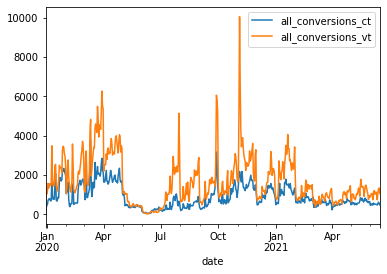

In [79]:
df.groupby('date')[['all_conversions_ct','all_conversions_vt']].sum().plot()

Note: when we group all data at the daily level, there is a strong relationship between spend, impressions, clickthrough conversions and the variable we care about: viewthrough conversions. This is a good indication that we can come up with a multiplier or model-based approach using some of this data. 

In [80]:
df.groupby('date')[['spend','impressions','all_conversions_ct','all_conversions_vt']].sum().corr()

,spend,impressions,all_conversions_ct,all_conversions_vt
spend,1.000000,0.879415,0.769344,0.726609
impressions,0.879415,1.000000,0.739251,0.757588
all_conversions_ct,0.769344,0.739251,1.000000,0.867618
all_conversions_vt,0.726609,0.757588,0.867618,1.000000


------------------

------------------

------------------

------------------

------------------

I decided to mess around and try a regression model with this data. Results look promising - there's definitely room to improve this model by getting creative with the inputs. 

This data is also currently grouped at the daily level. Each day just has one count of impressions, spend, and clickthrough conversions. For this analysis to be a bit more usable we'll need to explore ways we can split up this data by publisher and see if we can get a read for individual channels (e.g. Google, Twitter, FB, etc...)

## _Try a Model_

In [81]:
test = df.groupby('date')[['impressions','clicks','all_conversions_ct','all_conversions_vt']].sum()

In [82]:
indep_vars = [col for col in test.columns if '_vt' not in col]

In [83]:
X = test[indep_vars]
y = test[['all_conversions_vt']]

In [84]:
# scaler = StandardScaler()
# scaled = scaler.fit_transform(X)

# X = pd.DataFrame(data=scaled, columns=X.columns)
# X['date'] = test.index.values
# X.set_index('date', inplace=True)

# y['date'] = test.index.values
# y.set_index('date', inplace=True)

In [85]:
X = sm.add_constant(X)

ols_test = sm.OLS(y, X).fit() 

ols_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     all_conversions_vt   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     857.6
Date:                Mon, 21 Jun 2021   Prob (F-statistic):          2.73e-203
Time:                        10:53:58   Log-Likelihood:                -4105.2
No. Observations:                 536   AIC:                             8218.
Df Residuals:                     532   BIC:                             8236.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -123.7693     42.390     -2.920      0.004    -207.041     -40.498
impressions         3.087e-05   2.06e-06     15.010      0.000    2.68e-05    3.49e-05
clicks                -0.0026      0.000    -11.966      0.000      -0.003      -0.002
all_conversions_ct     1.4049      0.055     25.448      0.000       1.296       1.513
==============================================================================
Omnibus:                      506.774   Durbin-Watson:                   0.801
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32992.036
Skew:                           3.879   Prob(JB):                         0.00
Kurtosis:                      40.644   Cond. No.                     7.02e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.02e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [86]:
ols_y_pred = ols_test.predict(X)

ols_vis = X.copy()
ols_vis['y_pred'] = ols_y_pred
ols_vis['y_actual'] = y
ol_vis['resid'] = ols_vis['y_pred'] - ols_vis['y_actual']

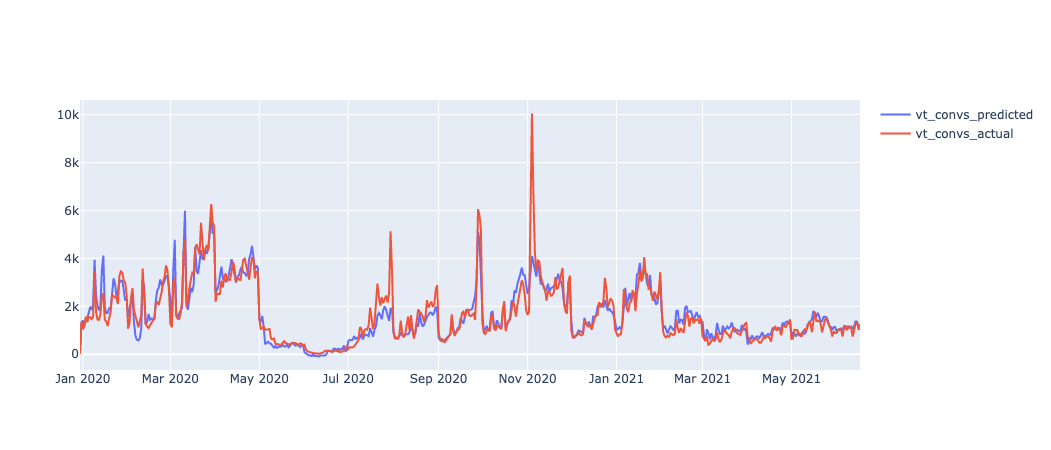

In [87]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_pred'],
                    mode='lines',
                    name='vt_convs_predicted'))
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_actual'],
                    mode='lines',
                    name='vt_convs_actual'))

fig.show()

__Try holding out the last few months__

In [92]:
is_s = '2019-01-01'
is_e = '2021-03-31'

oos_s = '2021-04-01'
oos_e = '2021-06-15'

X_train = X.loc[is_s:is_e]
X_test = X.loc[oos_s:oos_e]

y_train = y.loc[is_s:is_e]
y_test = y.loc[oos_s:oos_e]

In [93]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)


ols = sm.OLS(y_train, X_train).fit() 

ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     all_conversions_vt   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     693.3
Date:                Mon, 21 Jun 2021   Prob (F-statistic):          4.79e-169
Time:                        11:17:20   Log-Likelihood:                -3539.5
No. Observations:                 458   AIC:                             7087.
Df Residuals:                     454   BIC:                             7103.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -95.5185     49.448     -1.932      0.054    -192.694       1.657
impressions         3.093e-05   2.25e-06     13.731      0.000    2.65e-05    3.54e-05
clicks                -0.0026      0.000    -11.142      0.000      -0.003      -0.002
all_conversions_ct     1.3914      0.060     23.092      0.000       1.273       1.510
==============================================================================
Omnibus:                      417.361   Durbin-Watson:                   0.797
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21733.316
Skew:                           3.649   Prob(JB):                         0.00
Kurtosis:                      35.948   Cond. No.                     7.43e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.43e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [94]:
#####################################
# TRAIN
######################################

train_ols_y_pred = ols.predict(X_train)

train_ols_vis = X_train.copy()
train_ols_vis['y_pred'] = train_ols_y_pred
train_ols_vis['y_actual'] = y_train
train_ols_vis['resid'] = train_ols_vis['y_pred'] - train_ols_vis['y_actual']

#####################################
# TEST
######################################
test_ols_y_pred = ols.predict(X_test)

test_ols_vis = X_test.copy()
test_ols_vis['y_pred'] = test_ols_y_pred
test_ols_vis['y_actual'] = y_test
test_ols_vis['resid'] = test_ols_vis['y_pred'] - test_ols_vis['y_actual']

######################################
# COMBINE
######################################

ols_vis = pd.concat([train_ols_vis,test_ols_vis])

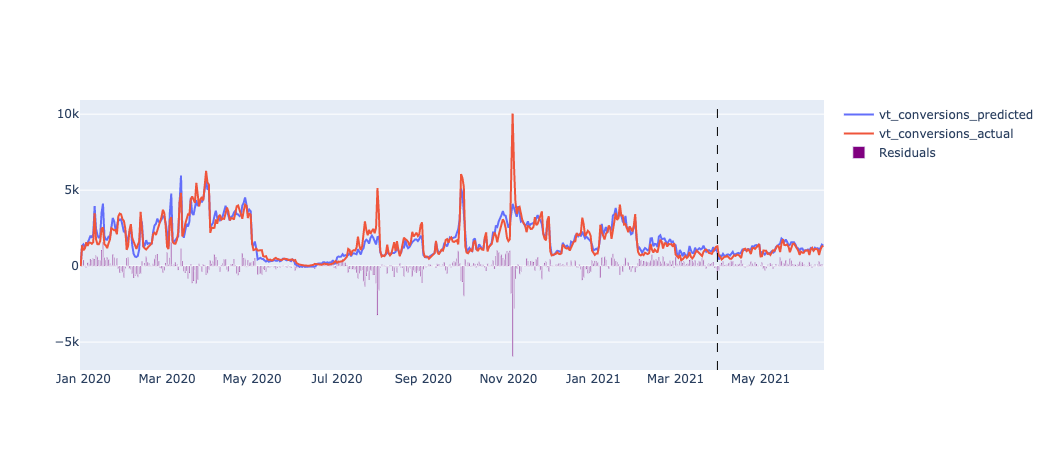

In [99]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_pred'],
                    mode='lines',
                    name='vt_conversions_predicted'))
fig.add_trace(go.Scatter(x=ols_vis.index, y=ols_vis['y_actual'],
                    mode='lines',
                    name='vt_conversions_actual'))
fig.add_trace(go.Bar(
    x=ols_vis.index,
    y=ols_vis['resid'],
    name='Residuals',
    marker_color='purple'
))

fig.add_vline(x='2021-03-31', line_width=1, line_dash="dash", line_color="black")

fig.show()

# __APPENDIX__

__Try Stepwise__

In [ ]:
import statsmodels.formula.api as smf


def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    i = 1
    while remaining and current_score == best_new_score:
        print(f"Iteration: {i}")
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
            print("New best model found")
            print(formula)
        i += 1
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

--------------

--------------

--------------

--------------

--------------